In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_columns', None)
from sklearn.model_selection import cross_validate

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Training set
ts_i = pd.read_csv('./Data/features_inter.csv')
ts_u = pd.read_csv('./Data/features_union.csv')
ts_i = ts_i.drop(['parcelid','logerror'],axis=1)
ts_u = ts_u.drop(['parcelid','logerror'],axis=1)
ts_i.head()

,Zestimate,finishedsquarefeet12,lotsizesquarefeet,taxamount,longitude,latitude,regionidzip,yearbuilt,month
0,10279.844084,1684.0,7528.0,6735.880000,-118.488536,34.280990,96370.0,1959.0,1
1,8450.157608,2263.0,3643.0,10153.020000,-117.677556,33.668120,96962.0,2014.0,1
2,9960.079893,2217.0,11423.0,5984.582647,-118.175032,34.136312,96293.0,1940.0,1
3,10220.393562,839.0,70859.0,3048.740000,-118.309000,33.755800,96222.0,1987.0,1
4,9950.124792,2283.0,6000.0,5488.960000,-117.700234,33.485643,96961.0,1981.0,1


In [3]:
# lr.score(X_test, y_test, sample_weight=1/y_test)
def mae_loss(t,p):
    sum = 0
    for i in range(t.shape[0]):
        sum += abs(t[i]-p[i])
    return sum/t.shape[0]

# mape = metrics.make_scorer(mape_loss, greater_is_better=False)

def metric_lr(X_train, y_train, X_test, y_test, model, cri):
    print("Intercept %s:" % model.intercept_)
    print("Coefficients %s:" % model.coef_)
    fit_time = 0
    score_time = 0
    test_score = 0
    train_score = 0
    result = cross_validate(model, X_test, y_test, scoring=cri)
    for i in range(3):
        fit_time += result['fit_time'][i]
        score_time += result['score_time'][i]
        test_score += result['test_score'][i]
        train_score += result['train_score'][i]
    pred = model.predict(X_test)
    m = mae_loss(y_test, pred)
    return [fit_time/3, score_time/3, test_score/3, train_score/3, m]
#     print("R Squared: %s" % model.score(X_test, y_test))
#     print("Mean Squared Error: %s" % metrics.mean_squared_error(y_test, y_pred))
#     print("Root MSE: %s" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#     print("Mean Absolute Percent Error: %.2f%%" % mape(y_test.reset_index()['logerror'], y_pred))

In [4]:
# Multi-Linear Regression with MRE
ts_list = [ts_i,ts_u]
model_list = []
frames = []
for i in range(2):
    print("Model %d:" % (i+1))
    ts = ts_list[i]
    y = ts[['Zestimate']]
    X = ts.drop('Zestimate',axis=1)
    
    # Split data with 0.75
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
    print (X_train.shape)
    print (y_train.shape)
    print (X_test.shape)
    print (y_test.shape)
    
    lr = LinearRegression(normalize=True)
    lr.fit(X_train, y_train)
    model_list.append(lr)
    metric = metric_lr(X_train, np.array(y_train), X_test, np.array(y_test), lr, 'neg_mean_squared_error')
    print(metric)
    result = pd.DataFrame.from_items([(i,metric)], \
                                     orient='index', \
                                     columns=['fit_time','score_time','test_score','train_score','MAE'])
    frames.append(result)
    print("****************************")
m = pd.concat(frames)
print(m)

Model 1:
(115563, 8)
(115563, 1)
(49528, 8)
(49528, 1)
Intercept [ 9064.51818541]:
Coefficients [[  5.71103774e-02   2.92274528e-05  -1.00887759e-02  -1.18324097e+01
   -6.87582831e+01   4.00927441e-04   9.25220104e-01   3.09868161e+00]]:


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


[0.010848283767700195, 0.0011499722798665364, -383185.57772959257, -382846.03507616353, array([ 427.02602344])]
****************************
Model 2:
(115563, 11)
(115563, 1)
(49528, 11)
(49528, 1)
Intercept [ 7962.00734509]:
Coefficients [[  5.55656258e-02   5.65420789e-05  -1.14727042e-02  -2.05957603e+01
   -7.85761507e+01  -2.05366309e-04   9.95220881e-01   2.77292690e+00
    5.23565779e+00   5.44907617e-12  -3.74137792e+00]]:
[0.018766005833943684, 0.0018184185028076172, -381905.42010065931, -381658.97378395125, array([ 426.80052405])]
****************************
   fit_time  score_time     test_score    train_score              MAE
0  0.010848    0.001150 -383185.577730 -382846.035076   [427.02602344]
1  0.018766    0.001818 -381905.420101 -381658.973784  [426.800524051]


In [5]:
best = model_list[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
pred = best.predict(X_test)
error = pred - y_test

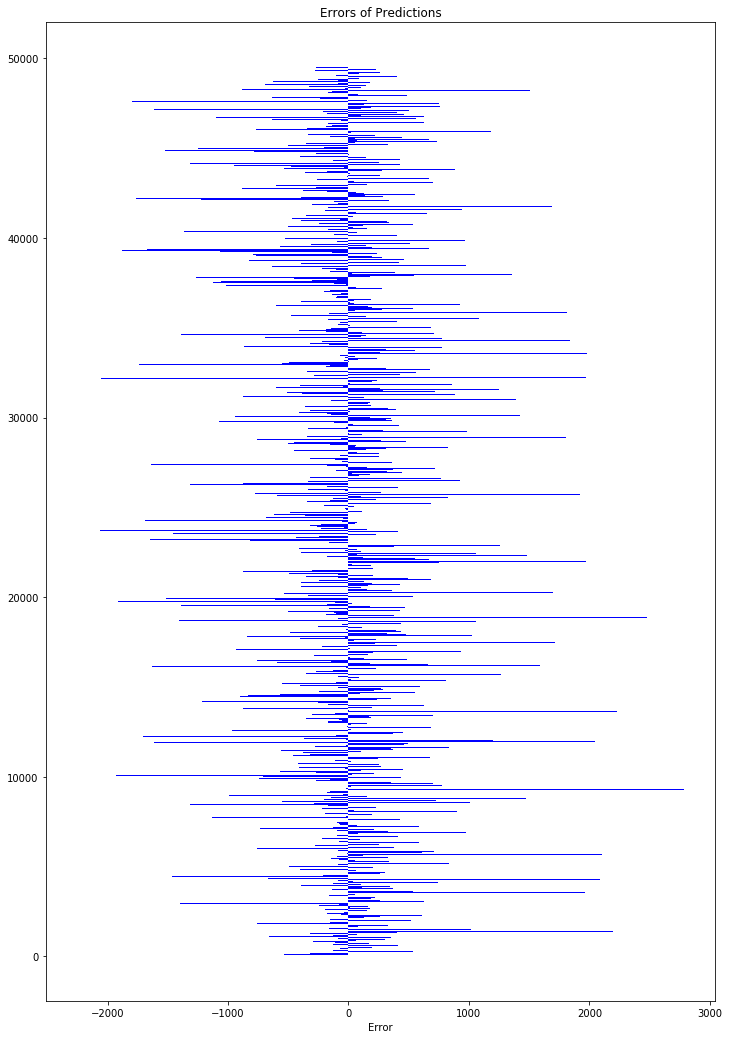

In [6]:
ind = np.arange(error.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, error.values, color='blue')
ax.set_xlabel("House")
ax.set_xlabel("Error")
ax.set_title("Errors of Predictions")
plt.show()

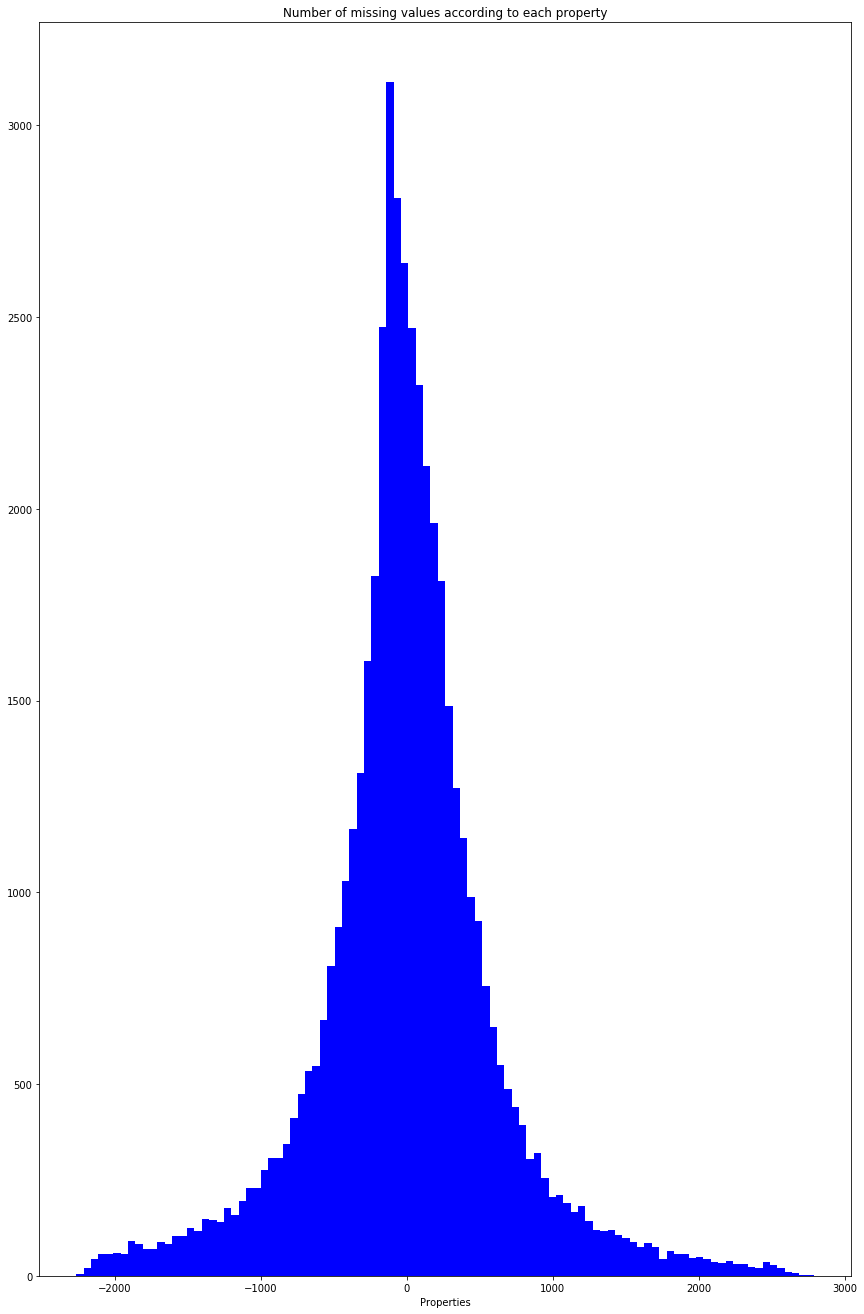

In [7]:
f, ax = plt.subplots(figsize=(12,18))
f.tight_layout()
rects = ax.hist(error.values, bins=100, color='blue')
ax.set_xlabel("Number of missing values")
ax.set_xlabel("Properties")
ax.set_title("Number of missing values according to each property")
plt.show()

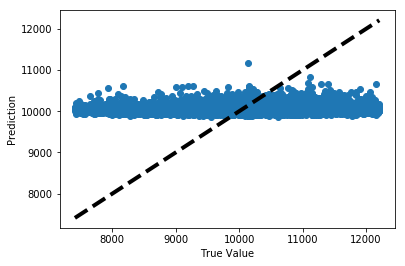

In [8]:
f, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('True Value')
ax.set_ylabel('Prediction')
plt.show()

In [110]:
# # Multi-Linear Regression with MAPE
# frames = []
# for i in range(5):
#     print("Round %d:" % (i+1))
#     lr = LinearRegression(normalize=True)
#     lr.fit(X_train, y_train)
#     metrics = metric_lr(X_train, y_train, X_test, y_test, lr, mape)
#     print(metrics)
#     result = pd.DataFrame.from_items([(i,metrics)], \
#                                      orient='index', \
#                                      columns=['fit_time','score_time','test_score','train_score'])
#     frames.append(result)
#     print("****************************")
# m = pd.concat(frames)
# print(m)

In [308]:
# from sklearn import datasets
# boston = datasets.load_boston()
# def df2skdata(df):
#     i = 0
#     skdata = []
#     for row in range(df.shape[0]):
#         j = 0
#         for co in range(df.shape[1]):
#             r = []
#             r.append(df.ix[i,j])
#         skdata.append(r)
#     return skdata